In [1]:
!pip install transformers
!pip install accelerate -U
!pip install datasets
!pip install torch-summary
!pip install graphviz
!pip install torchview
!pip install bertviz

repo_path = "https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/"
branch = "ire"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
utils_url = f"{repo_path}{branch}/utils.py"
evaluation_url = f"{repo_path}{branch}/evaluation.py"

import os
if os.path.exists("utils.py"):
  !rm "utils.py"
if os.path.exists("evaluation.py"):
  !rm "evaluation.py"

!wget {utils_url}
!wget {evaluation_url}

--2023-06-26 07:12:36--  https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/ire/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13989 (14K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]  13.66K  --.-KB/s    in 0s      

2023-06-26 07:12:36 (68.7 MB/s) - ‘utils.py’ saved [13989/13989]

--2023-06-26 07:12:36--  https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/ire/evaluation.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10675 (10K) [text/plai

In [3]:
import json
import torch
import pandas as pd
import numpy as np
from transformers import BertModel, AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, TrainerCallback, EarlyStoppingCallback
from transformers.modeling_outputs import SequenceClassifierOutput
from torch.nn import BCEWithLogitsLoss
import importlib
import sys
from utils import *
importlib.reload(sys.modules['utils'])

<module 'utils' from '/content/utils.py'>

In [4]:
# set CUDA if available
"""if torch.cuda.is_available():
    device = torch.device('cuda')
    print("======= CUDA Available =======")
else:
    device = torch.device('cpu')
    print("======= CUDA NOT Available, run on CPU =======")"""
device = torch.device('cpu') # otw goes out of memory

In [5]:
NUM_LABELS = 8

model_config = {
    'model_id': 'bert_custom_baseline',
    'tokenizer_name': 'bert-base-cased',
    'model_name': 'bert-base-cased',
    'train_batch_size': 4,
    'val_batch_size': 4,
    'learning_rate': 2e-5,
    'weight_decay': 0.01,
    'epochs': 1,
    'seed': 42,
    'patience': 3,
    'early_stopping_threshold': 0
} # TODO: expand...

tokenizer = AutoTokenizer.from_pretrained(model_config['tokenizer_name'], truncation=True)

In [6]:
class BERTClassifier(torch.nn.Module):
  def __init__(self, num_labels, num_features):
    self.num_labels = num_labels
    super(BERTClassifier, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-uncased')
    self.dropout = torch.nn.Dropout(0.3)
    self.linear = torch.nn.Linear(768+num_features, self.num_labels)

  def forward(self, input_ids, attention_mask=None,  token_type_ids=None, labels=None, features=None, output_attentions=False):
    outputs = self.bert(
      input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids,
      output_attentions=True
    ) # outputs type is BaseModelOutputWithPoolingAndCrossAttentions
    # dropout_output = self.dropout(outputs[0]) # outputs[0]=last hidden state, with shape (batch_size, sequence_length, hidden_size)
    # logits = self.linear(dropout_output[:,0,:].view(-1,768)) # from batch_size,1,768 to batch size, 768
    dropout_output = self.dropout(outputs.pooler_output) # above the clf token there is linear and tanh
    if features is not None:
      dropout_output = torch.cat((dropout_output, features), dim=1)
    logits = self.linear(dropout_output)
    loss = None
    if labels is not None:
      loss = BCEWithLogitsLoss()(logits, labels)
    return SequenceClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states,attentions=outputs.attentions)

In [7]:
TRAIN_DATA = f"{repo_path}{branch}/datasets/WASSA23_essay_level_train_preproc.tsv"
VAL_DATA = f"{repo_path}{branch}/datasets/WASSA23_essay_level_val_preproc.tsv"
DEV_DATA = f"{repo_path}{branch}/datasets/WASSA23_essay_level_dev_preproc.tsv"

train_df = pd.read_csv(TRAIN_DATA, sep='\t')
val_df = pd.read_csv(VAL_DATA, sep='\t')
dev_df = pd.read_csv(DEV_DATA, sep='\t')

# TODO: come trattare unkown? inferirli?
# per adesso gli unknown in gender, race e education sono trattati come se fossero una categoria a parte, in age e income sono settati a 0)
train_df['age'] = train_df['age'].replace('unknown', '0')
val_df['age'] = val_df['age'].replace('unknown', '0')
dev_df['age'] = dev_df['age'].replace('unknown', '0')
train_df['income'] = train_df['income'].replace('unknown', '0')
val_df['income'] = val_df['income'].replace('unknown', '0')
dev_df['income'] = dev_df['income'].replace('unknown', '0')

train_df = train_df.astype({"gender": str, "education": str, "race": str, "age": int, "income": int})
val_df = val_df.astype({"gender": str, "education": str, "race": str, "age": int, "income": int})
dev_df = dev_df.astype({"gender": str, "education": str, "race": str, "age": int, "income": int})

emotions_encoder = EmotionsLabelEncoder()
emotions_encoder.fit(train_df.emotion)
y_train = emotions_encoder.encode(train_df.emotion)
y_val = emotions_encoder.encode(val_df.emotion)
y_dev = emotions_encoder.encode(dev_df.emotion)

features_encoder = FeaturesEncoder()
features_encoder.fit(train_df[['gender', 'age']])
features_train = features_encoder.encode(train_df[['gender', 'age']])
features_val = features_encoder.encode(val_df[['gender', 'age']])
features_dev = features_encoder.encode(dev_df[['gender', 'age']])

In [8]:
############################ SUB-SAMPLE ############################
train_df = train_df[:20]
val_df = val_df[:10]
dev_df = dev_df[:10]
####################################################################

train_set = EMODataset(tokenizer=tokenizer, essay=train_df.essay, targets=y_train, features=features_train)
val_set = EMODataset(tokenizer=tokenizer, essay=val_df.essay, targets=y_val, features=features_val)
dev_set = EMODataset(tokenizer=tokenizer, essay=dev_df.essay, targets=y_dev, features=features_dev)

model = BERTClassifier(num_labels=NUM_LABELS, num_features=features_train.shape[1])
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [9]:
train_arguments = TrainingArguments(
    output_dir="./",
    per_device_train_batch_size=model_config['train_batch_size'],
    per_device_eval_batch_size=model_config['val_batch_size'],
    num_train_epochs=model_config['epochs'],
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=model_config['learning_rate'],
    weight_decay=model_config['weight_decay'],
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    seed=model_config['seed']
) # TODO: custom other params

trainer = Trainer(
    model=model,
    args=train_arguments,
    train_dataset=train_set,
    eval_dataset=val_set,
    tokenizer=tokenizer,
    compute_metrics=compute_EMO_metrics_trainer
)

class TrainerLoggingCallback(TrainerCallback):
    def __init__(self, log_path):
        self.log_path = log_path

    def on_log(self, args, state, control, logs=None, **kwargs):
        _ = logs.pop("total_flos", None)
        if state.is_local_process_zero: # whether this process is the main one in a distributed setting
            with open(self.log_path, "a") as f:
                f.write(json.dumps(logs) + "\n")

trainer.add_callback(EarlyStoppingCallback(
    early_stopping_patience=model_config['patience'],
    early_stopping_threshold=model_config['early_stopping_threshold']))
trainer.add_callback(TrainerLoggingCallback(model_config['model_id']+"_log.json"))

In [10]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Sklearn Accuracy,Roc Auc Micro,Accuracy,Micro Precision,Micro Recall,Micro F,Macro Precision,Macro Recall,Macro F
1,No log,0.541470,0.000000,0.539610,0.111111,0.285714,0.153846,0.200000,0.035714,0.083333,0.050000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=5, training_loss=0.5206494808197022, metrics={'train_runtime': 183.1559, 'train_samples_per_second': 0.109, 'train_steps_per_second': 0.027, 'train_loss': 0.5206494808197022, 'epoch': 1.0})

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


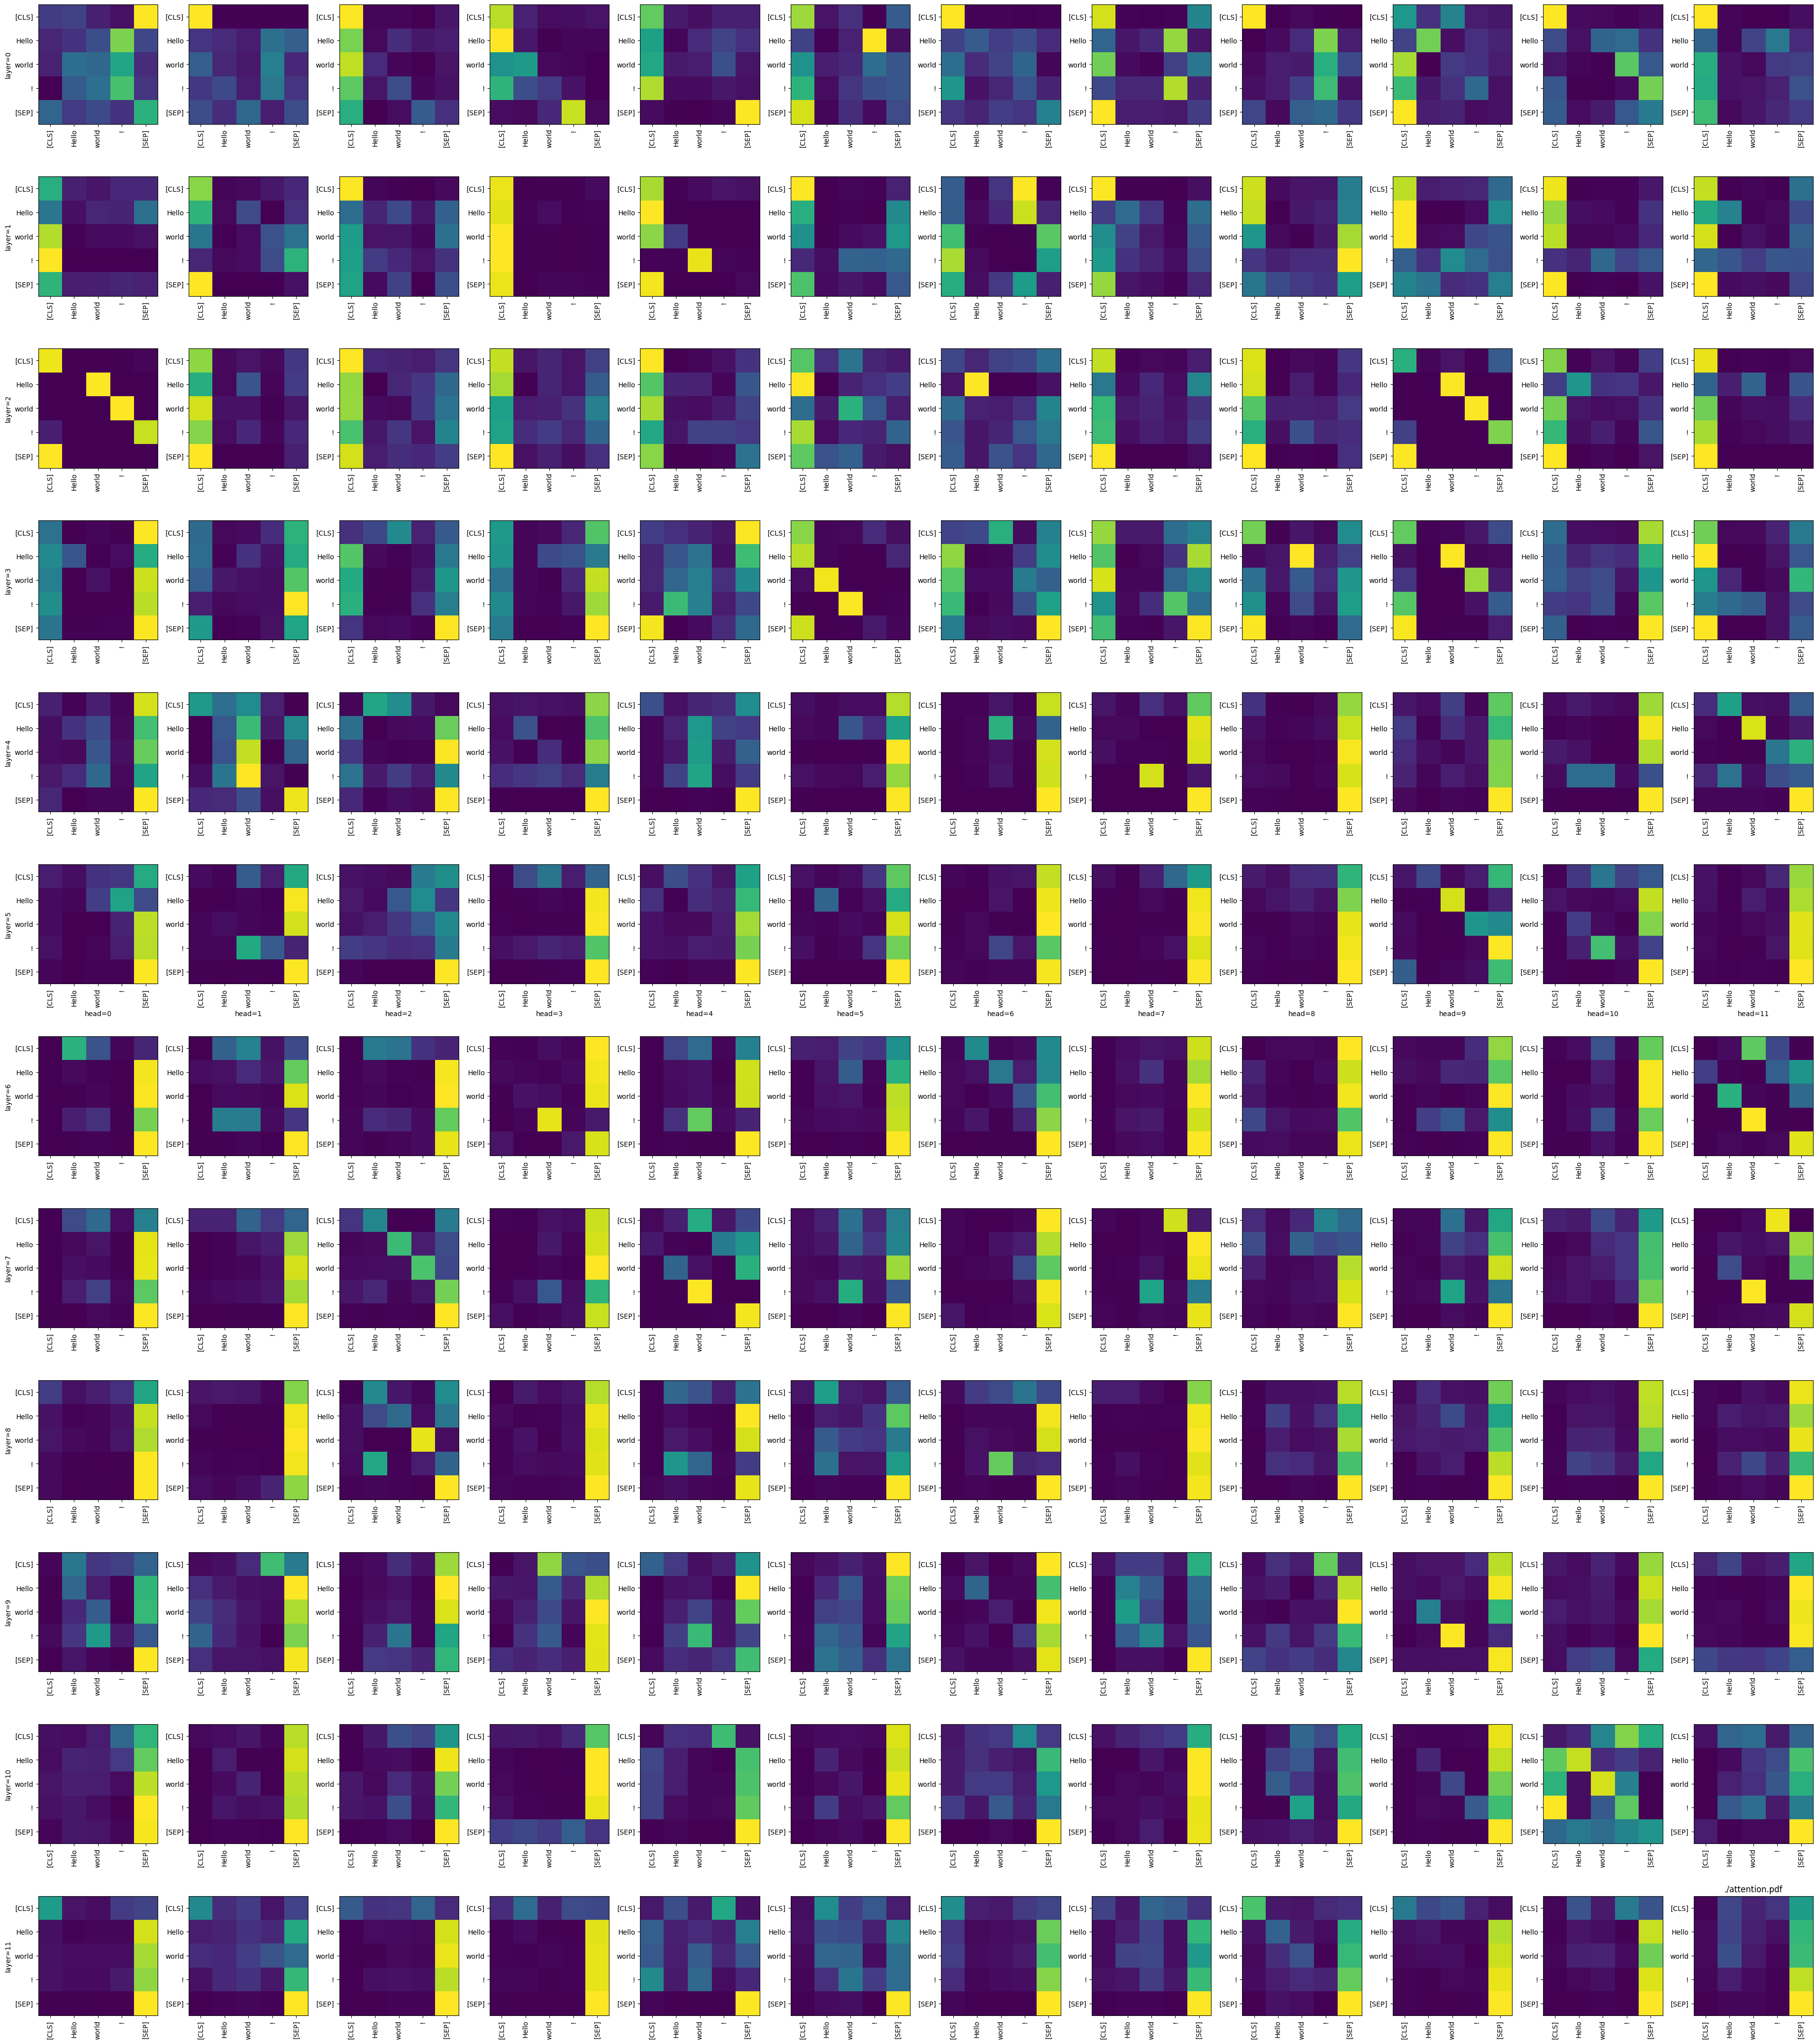

In [11]:
model = BERTClassifier(num_labels=NUM_LABELS, num_features=0)
input_str = "Hello world!"
plot_attentions(input_str, model, tokenizer, "./attention.pdf", "bert-base-cased")

In [1]:
# Define your gold labels
gold_emotions = ['Hope/Sadness', 'Anger', 'Sadness', 'Neutral', 'Disgust/Sadness',
       'Anger/Disgust', 'Fear/Sadness', 'Joy', 'Hope', 'Joy/Neutral',
       'Disgust', 'Neutral/Sadness', 'Neutral/Surprise', 'Anger/Neutral',
       'Hope/Neutral', 'Surprise', 'Anger/Sadness', 'Fear', 'Anger/Joy',
       'Disgust/Fear', 'Fear/Neutral', 'Fear/Hope', 'Joy/Sadness',
       'Anger/Disgust/Sadness', 'Anger/Surprise', 'Disgust/Neutral',
       'Anger/Fear', 'Sadness/Surprise', 'Disgust/Surprise', 'Anger/Hope']

# Define the desired label names
label_names = ['Anger', 'Disgust', 'Fear', 'Hope', 'Joy', 'Neutral', 'Sadness', 'Surprise']

# Compute the confusion matrix
cm = confusion_matrix(gold_emotions, gold_emotions, labels=label_names)

# Plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')

# Customize the plot
ax.set_xticks(np.arange(len(label_names)))
ax.set_yticks(np.arange(len(label_names)))
ax.set_xticklabels(label_names, rotation=45)
ax.set_yticklabels(label_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Show the plot
plt.tight_layout()
plt.show()

NameError: name 'confusion_matrix' is not defined